# `causalml` - Meta-Learner Example Notebook

# Introduction
CausalML is a Python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms based on recent research. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data. Essentially, it estimates the causal impact of intervention T on outcome Y for users with observed features X, without strong assumptions on the model form.  The package currently supports the following methods:
- Tree-based algorithms
    - Uplift tree/random forests on KL divergence, Euclidean Distance, and Chi-Square
    - Uplift tree/random forests on Contextual Treatment Selection
- Meta-learner algorithms
    - S-learner
    - T-learner
    - X-learner
    - R-learner
    
In this notebook, we will generate some synthetic data to demonstrate how to use the various Meta-Learner algorithms in order to estimate Individual Treatment Effects (and Average Treatment Effects with confidence intervals).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
import causalml
print(causalml.__version__)

0.3.0


# Part A: Example Workflow using Synthetic Data

### Generate synthetic data
- We have implemented 4 modes of generating synthetic data (specified by input parameter `mode`). Refer to the References section for more detail on these data generation processes.

In [4]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

### Calculate Average Treatment Effect (ATE)
A meta-learner can be instantiated by calling a base learner class and providing an sklearn/xgboost regressor class as input. Alternatively, we have provided some ready-to-use learners that have already inherited their respective base learner class capabilities. This is more abstracted and allows these tools to be quickly and readily usable.

In [5]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1]))
print('ATE upper bound: {:.03f}'.format(ate_s[2]))

(0.688822438283459, 0.6406780501581677, 0.7369668264087503)
ATE estimate: 0.689
ATE lower bound: 0.641
ATE upper bound: 0.737


In [6]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(0.578665, 0.5409527022710967, 0.6163773338922334)

Using the BaseTRegressor class and using XGB (same result):
(0.578665, 0.5409527022710967, 0.6163773338922334)

Using the BaseTRegressor class and using Linear Regression (different result):
(0.6802251518756077, 0.6397062845538052, 0.7207440191974103)


In [7]:
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(0.5320799428302647, 0.4946311232408827, 0.5695287624196467)

Using the BaseXRegressor class and using Linear Regression:
(0.6802251518756073, 0.6397062845538047, 0.7207440191974098)


In [8]:
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(0.5109694, 0.5105636278247135, 0.511375172987054)
Using the BaseRRegressor class and using Linear Regression:
(0.5110754822513415, 0.5106633031544878, 0.5114876613481951)


### 7. Calculate Individual Treatment Effect (ITE/CATE)
CATE stands for Conditional Average Treatment Effect.

In [9]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, p=e, treatment=treatment, y=y)

# R Learner
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, p=e, treatment=treatment, y=y)

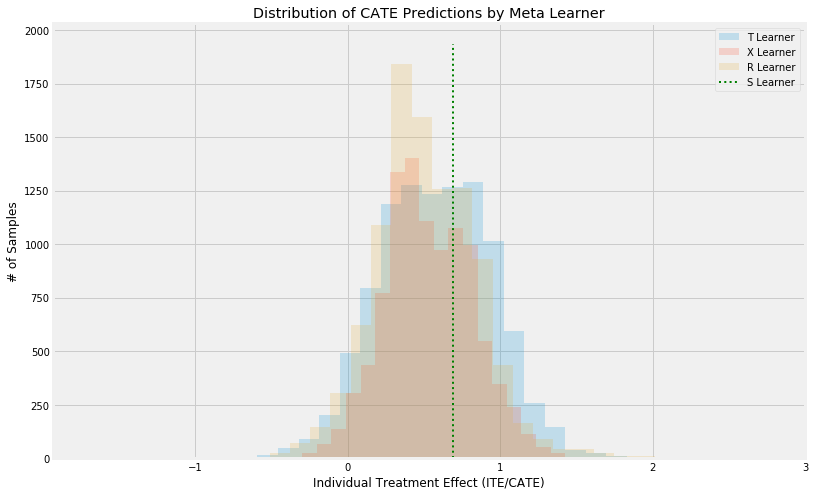

In [10]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

# Part B: Validating Meta-Learner Accuracy

We will validate the meta-learners' performance based on the same synthetic data generation method in Part A (`simulate_nuisance_and_easy_treatment`).

In [11]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [12]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.400132,0.083443,3.803305
S Learner (XGB),0.157819,0.026045,0.185219
T Learner (LR),0.380709,0.042061,0.355698
T Learner (XGB),0.173595,0.072736,0.318280
X Learner (LR),0.380709,0.042061,0.355698
X Learner (XGB),0.110710,0.034676,0.101053
R Learner (LR),0.325631,0.040661,0.324708
R Learner (XGB),0.074038,0.055802,0.070099


In [13]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.402878,0.083616,3.785810
S Learner (XGB),0.158181,0.026011,0.218959
T Learner (LR),0.381523,0.042024,0.380212
T Learner (XGB),0.173613,0.068561,0.323802
X Learner (LR),0.381523,0.042024,0.380212
X Learner (XGB),0.109432,0.032447,0.120430
R Learner (LR),0.326200,0.040528,0.355620
R Learner (XGB),0.075203,0.052057,0.085725


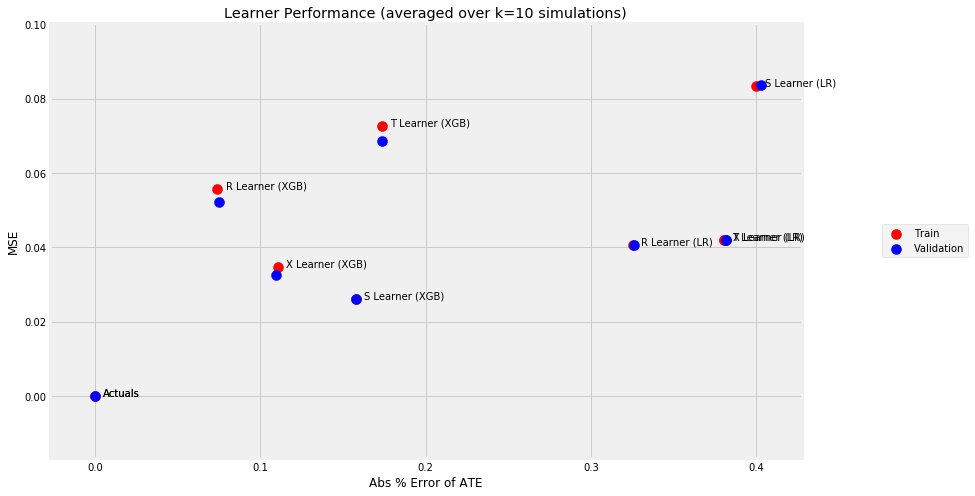

In [14]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

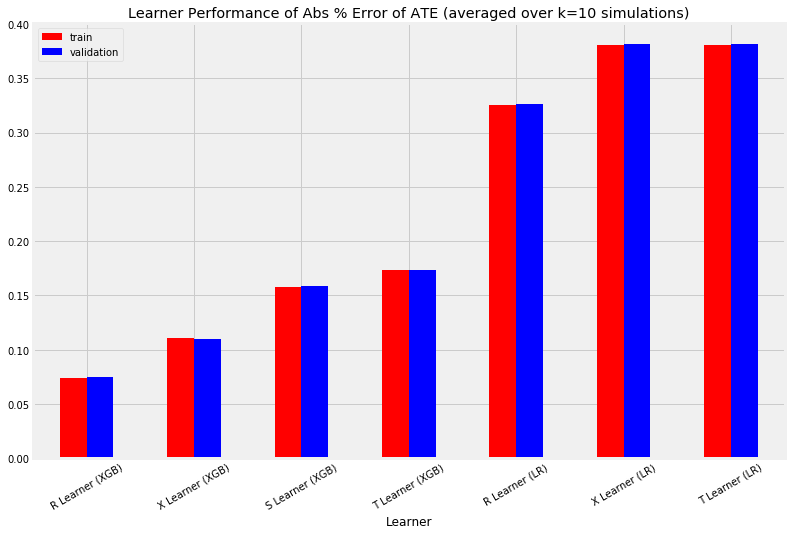

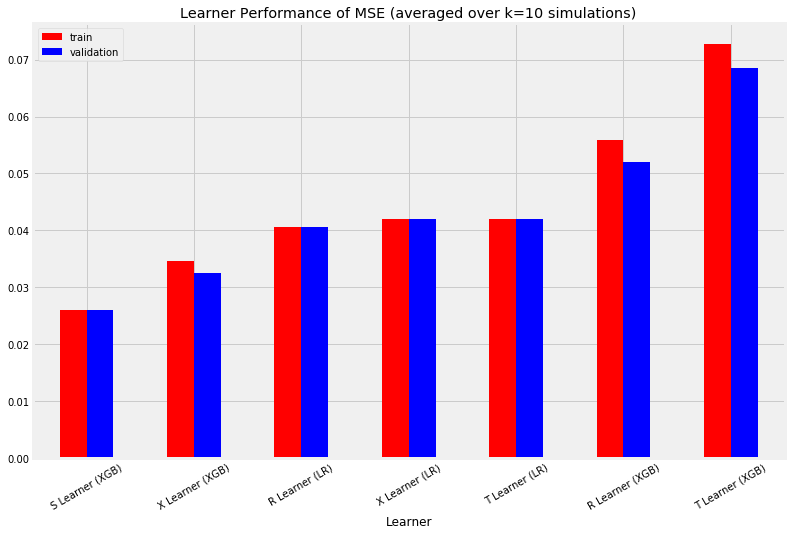

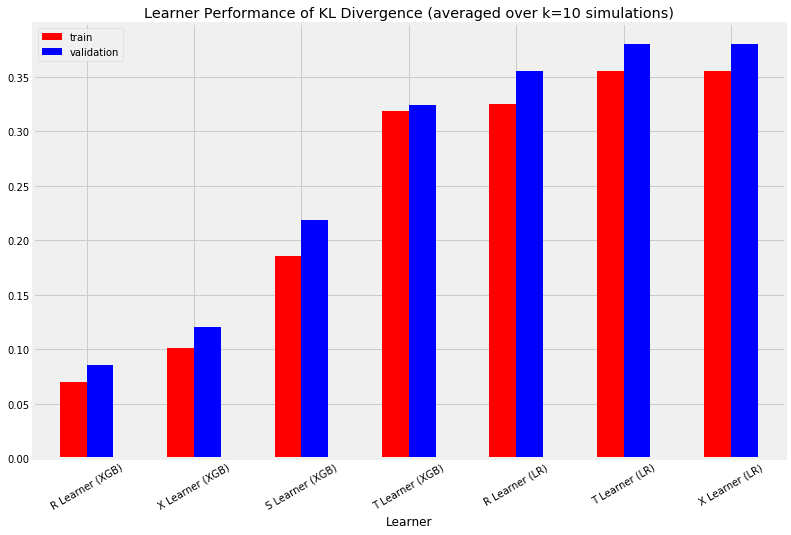

In [15]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [16]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

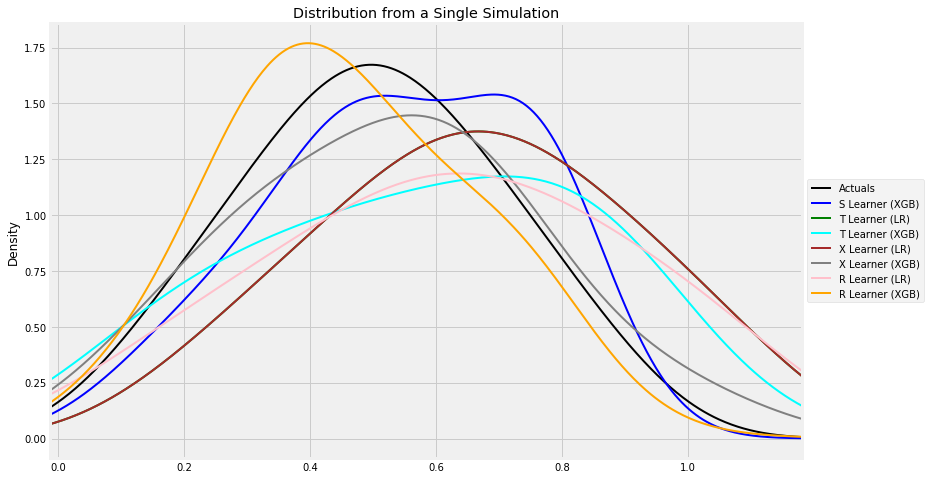

In [17]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

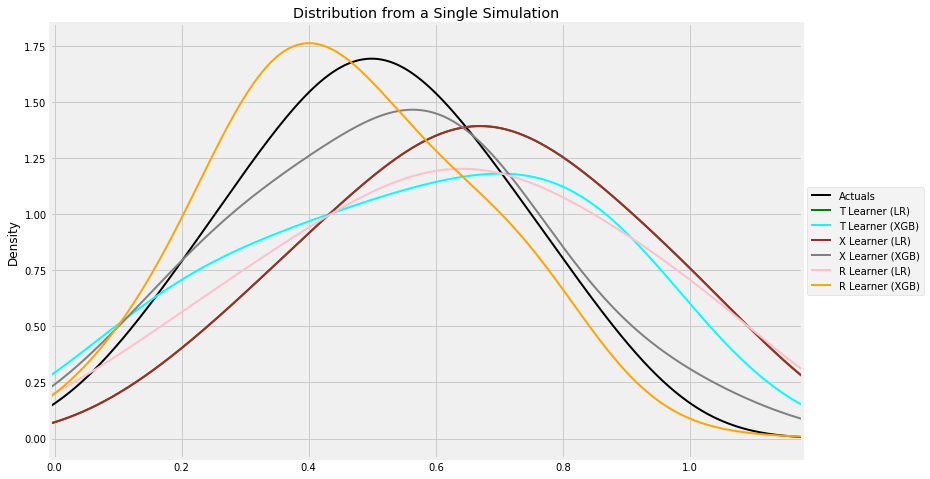

In [18]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

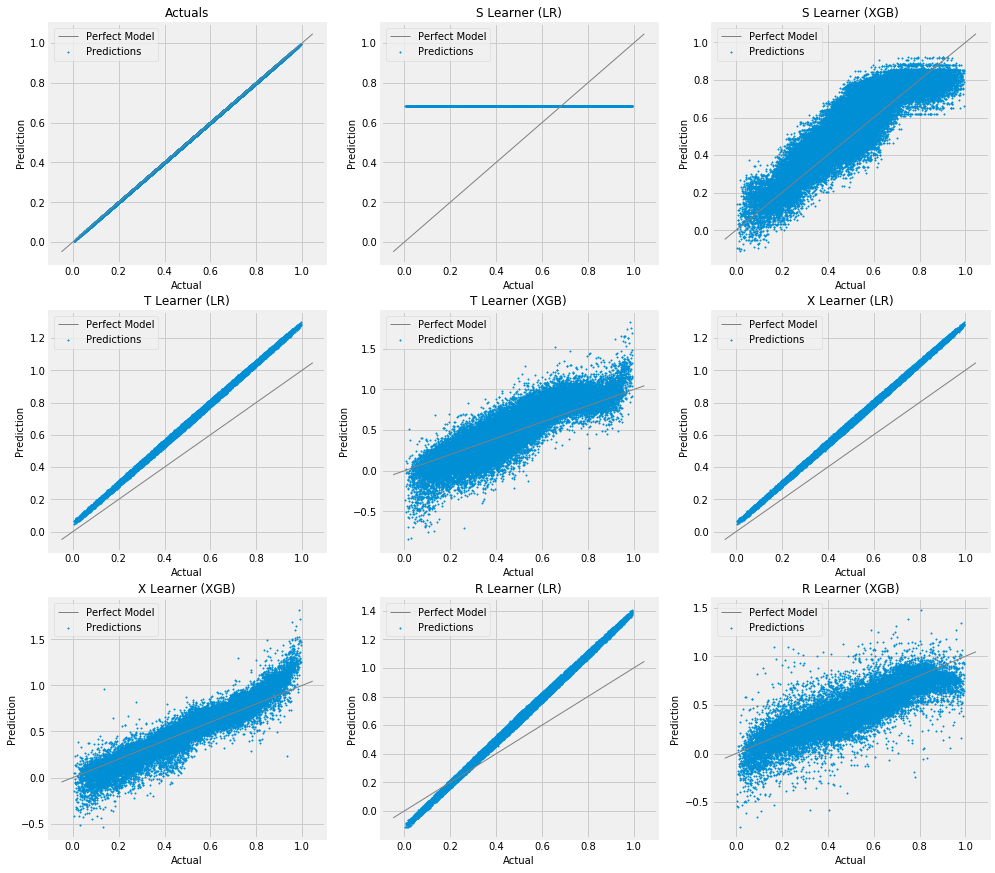

In [19]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

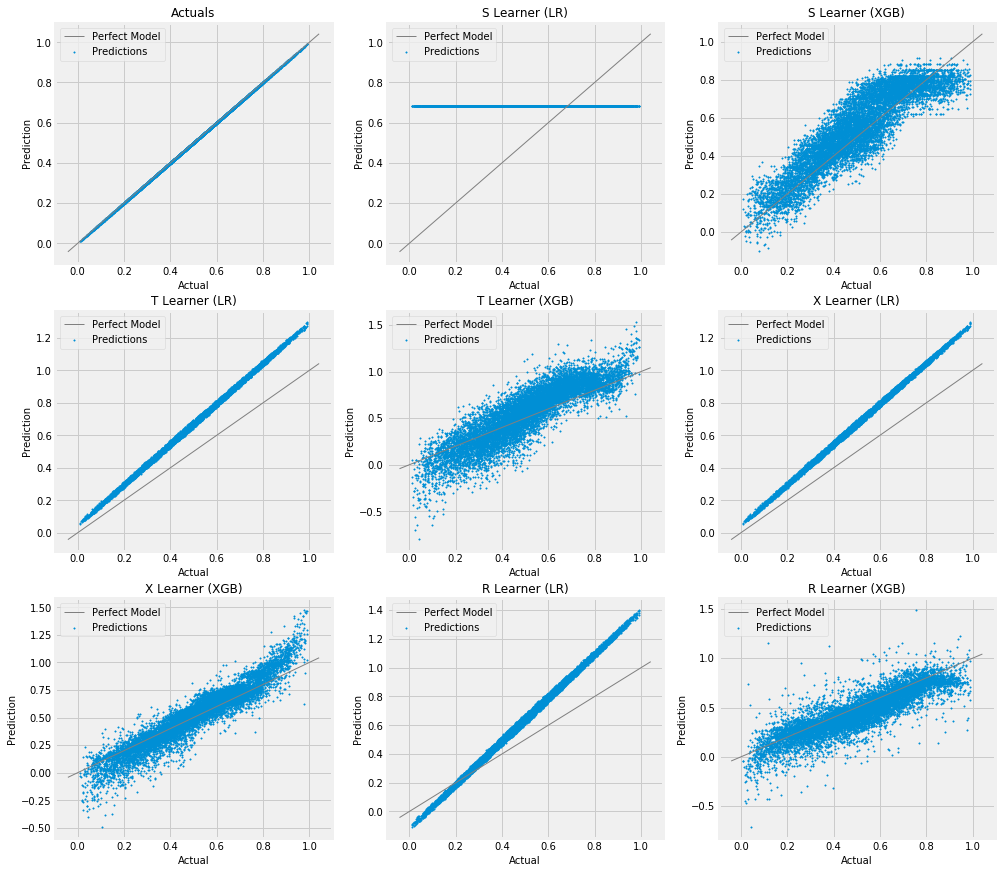

In [20]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,12346.236652
2,T Learner (LR),12344.878454
4,X Learner (LR),12344.878454
6,R Learner (LR),12343.806899
5,X Learner (XGB),12243.511442
1,S Learner (XGB),12118.814146
3,T Learner (XGB),12103.773044
7,R Learner (XGB),12054.078943
8,Random,10003.508033


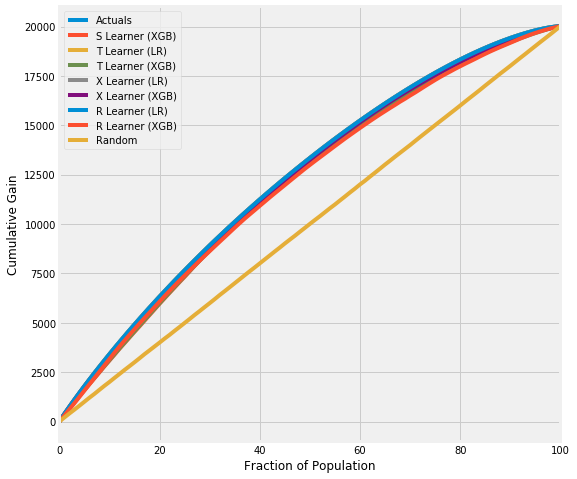

In [21]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,3082.623580
2,T Learner (LR),3082.270303
4,X Learner (LR),3082.270303
6,R Learner (LR),3081.989542
5,X Learner (XGB),3057.342349
1,S Learner (XGB),3024.875358
3,T Learner (XGB),3022.262108
7,R Learner (XGB),3012.055464
8,Random,2499.071272


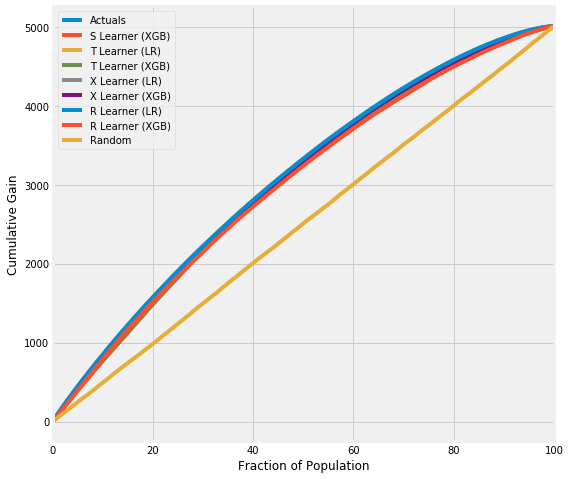

In [22]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])